In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
data.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [ ]:
train_size = int(len(data) * 0.95)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [ ]:
import numpy as np

In [ ]:
def create_seq(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
X_train, y_train = create_seq(train[['close']], train.close, 30)
X_test, y_test = create_seq(test[['close']], test.close, 30)

print(X_train.shape)
print(X_test.shape)

(7752, 30, 1)
(380, 30, 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [ ]:
X_train.shape

(7752, 30, 1)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 64)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             65        
 ributed)                                                        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit( X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 [==============================] - 12s 35ms/step - loss: 0.1456 - val_loss: 0.3170
Epoch 2/10
218/218 [==============================] - 8s 35ms/step - loss: 0.0870 - val_loss: 0.1834
Epoch 3/10
218/218 [==============================] - 7s 34ms/step - loss: 0.0640 - val_loss: 0.2321
Epoch 4/10
218/218 [==============================] - 7s 31ms/step - loss: 0.0704 - val_loss: 0.2552
Epoch 5/10
218/218 [==============================] - 8s 34ms/step - loss: 0.0774 - val_loss: 0.2880
Epoch 6/10
218/218 [==============================] - 7s 33ms/step - loss: 0.0795 - val_loss: 0.3681
Epoch 7/10
218/218 [==============================] - 10s 44ms/step - loss: 0.0862 - val_loss: 0.3807
Epoch 8/10
218/218 [==============================] - 7s 32ms/step - loss: 0.0884 - val_loss: 0.3635
Epoch 9/10
218/218 [==============================] - 7s 34ms/step - loss: 0.0967 - val_loss: 0.3046
Epoch 10/10
218/218 [==============================] - 8s 36ms/step - loss: 0.1047 - val_

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 14ms/step - loss: 0.7257


0.7256825566291809

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 4s 12ms/step


In [ ]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 11ms/step


Reconstruction error threshold: 0.736741320013137


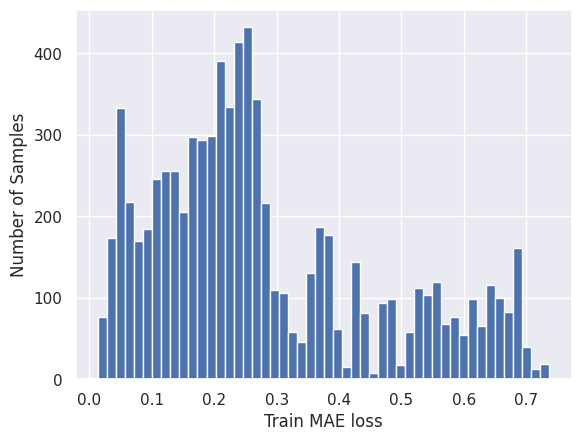

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)

print(f'Reconstruction error threshold: {threshold}')

In [ ]:
test_score_df = pd.DataFrame(index=test[30:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[30:].close

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-11-13,0.736921,0.736741,True,2.986280
2017-11-14,0.740696,0.736741,True,2.975067
2017-11-15,0.744469,0.736741,True,2.948301
2017-11-16,0.749206,0.736741,True,2.987783
2017-11-17,0.750908,0.736741,True,2.975029
